In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import random
from jaxtyping import Array, Float
from numpyro.contrib.control_flow import scan

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

In [2]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str

mdata = sm.datasets.macrodata.load_pandas().data

# prepare the dates index
dates = mdata[["year", "quarter"]].astype(int).astype(str)

quarterly = dates["year"] + "Q" + dates["quarter"]

quarterly = dates_from_str(quarterly)

mdata = mdata[["realgdp", "realcons", "realinv"]]

mdata.index = pd.DatetimeIndex(quarterly, freq="QE")

data = np.log(mdata).diff().dropna()

data.head()

,realgdp,realcons,realinv
1959-06-30,0.024942,0.015286,0.080213
1959-09-30,-0.001193,0.010386,-0.072131
1959-12-31,0.003495,0.001084,0.034425
1960-03-31,0.022190,0.009534,0.102664
1960-06-30,-0.004685,0.012572,-0.106694


In [3]:
var_model = VAR(data)

var_results = var_model.fit(maxlags=2)

var_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 01, Oct, 2025
Time:                     19:57:46
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001527         0.001119            1.365           0.172
L1.realgdp         -0.279435         0.169663           -1.647           0.100
L1.realcons         0.675016         0.131285            5.142    

In [4]:
y: Float[Array, "time vars"] = jnp.array(data)

In [ ]:
def model(y: Float[Array, "time vars"], n_lags: int):
    n_time, n_vars = y.shape

    # Sample parameters without plates first to avoid issues
    constant = numpyro.sample("constant", dist.Normal(0, 1).expand([n_vars]))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1.0).expand([n_vars]))

    l_omega = numpyro.sample(
        "l_omega", dist.LKJCholesky(dimension=n_vars, concentration=1.0)
    )
    l_sigma = sigma[..., None] * l_omega

    # Sample phi coefficients - shape (n_lags, n_vars, n_vars)
    phi = numpyro.sample(
        "phi", dist.Normal(0, 10).expand([n_lags, n_vars, n_vars]).to_event(3)
    )

    def transition(carry, t):
        # carry: (n_lags, n_vars)
        y_lags = carry

        # Compute VAR mean
        lag_contributions = jnp.einsum("lij,lj->i", phi, y_lags)
        m_t = constant + lag_contributions

        # Sample observation
        y_t = numpyro.sample(
            f"y_{t}",
            dist.MultivariateNormal(loc=m_t, scale_tril=l_sigma),
            obs=y[t] if y is not None else None,
        )

        # Update carry: remove oldest, add newest
        new_carry = jnp.concatenate([y_lags[1:], y_t[None, :]], axis=0)
        return new_carry, y_t

    # Initialize and run scan
    init_carry = y[:n_lags]
    time_indices = jnp.arange(n_lags, n_time)

    _, y_pred = scan(transition, init=init_carry, xs=time_indices)

    return y_pred

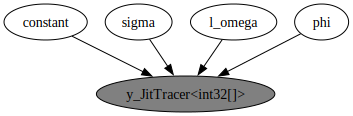

In [57]:
numpyro.render_model(model, model_kwargs={"y": y, "n_lags": 2})

In [58]:
# Run MCMC inference
from numpyro.infer import MCMC, NUTS

# Set up the MCMC sampler
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=2000, num_chains=2)

# Run inference
rng_key, rng_subkey = random.split(rng_key)
mcmc.run(rng_subkey, y=y, n_lags=2)

# Get samples
samples = mcmc.get_samples()

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [59]:
idata = az.from_numpyro(
    mcmc,
    coords={"var_1": data.columns, "var_2": data.columns, "lag": jnp.arange(1, 3)},
    dims={
        "constant": ["vars"],
        "sigma": ["vars"],
        "l_omega": ["var_1", "var_2"],
        "phi": ["lag", "var_1", "var_2"],
    },
)

In [60]:
idata["posterior"]["phi"].mean(dim=["chain", "draw"]).sel(var_2="realcons", lag=1)

<xarray.DataArray 'phi' (var_1: 3)> Size: 12B
array([0.2933966 , 0.2353912 , 0.81101584], dtype=float32)
Coordinates:
  * var_1    (var_1) object 24B 'realgdp' 'realcons' 'realinv'
    var_2    <U8 32B 'realcons'
    lag      int32 4B 1

In [ ]:
a = idata["posterior"]["l_omega"].mean(dim=["chain", "draw"])

In [70]:
corr = a.to_numpy() @ a.to_numpy().T
corr

array([[1.        , 0.59821326, 0.7467372 ],
       [0.59821326, 0.9967341 , 0.12530617],
       [0.7467372 , 0.12530617, 0.99632525]], dtype=float32)